# Chess Player Analysis - ML Training Pipeline
## Complete Guide for Training Your Chess AI Model

This notebook will guide you through:
1. Installing required dependencies
2. Downloading training data from Lichess/Chess.com
3. Analyzing games with Stockfish
4. Training the ML model
5. Saving the model to Google Drive

**Time Required:** 2-4 hours (mostly automated)
**Skill Level:** Beginner-friendly with step-by-step instructions

## Step 1: Setup Google Colab Environment
Let's first mount Google Drive to save our trained models

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create directory for our project
import os
project_dir = '/content/drive/MyDrive/chess_ai_project'
os.makedirs(project_dir, exist_ok=True)
os.chdir(project_dir)
print(f"Working directory: {os.getcwd()}")

Mounted at /content/drive
Working directory: /content/drive/MyDrive/chess_ai_project


## Step 2: Install Required Libraries
This will take 2-3 minutes

In [3]:
# Install chess library and Stockfish
!pip install python-chess --quiet
!pip install chess --quiet
!pip install xgboost --quiet
!pip install lightgbm --quiet
!pip install scikit-learn --quiet
!pip install pandas numpy matplotlib seaborn --quiet
!pip install requests --quiet
!pip install python-chess tqdm


# Install Stockfish engine
!apt-get install -y stockfish --quiet

print("✓ All dependencies installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 53.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Reading package lists...
Building dependency tree...
Reading state information...
Suggested packages:
  polyglot xboard | scid
The following NEW packages will be installed:
  stockfish
0 upgraded, 1 newly installed, 0 to remove and 1 not upgraded.
Need to get 24.8 MB of archives.
After this operation, 47.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 stockfish amd64 14.1-1 [24.8 MB]
Fetched 24.8 MB in 2s (16.3 MB/s)
Selecting previously unselected package stockfish.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../stockfish_14.1-1_amd64.deb ...
Unpacking stockfish (14.1-1) ...
Setting up stockfish (14.1-1) ...
Processing triggers for man-db (2.10.2-1) ...
✓ All dependencies installed successfully!


## Step 3: Upload Python Files
Upload the three Python files we created:
1. `chess_analyzer.py`
2. `ml_trainer.py`
3. `api_server.py` (optional, for later deployment)

**HOW TO UPLOAD:**
1. Click the folder icon on the left sidebar
2. Click the upload icon
3. Select the three Python files
4. Wait for upload to complete

Run the cell below to verify files are present:

In [4]:
# Verify files are present
required_files = ['/content/chess_analyzer.py', '/content/ml_trainer.py']
for file in required_files:
    if os.path.exists(file):
        print(f"✓ {file} found")
    else:
        print(f"✗ {file} NOT FOUND - Please upload it!")

✓ /content/chess_analyzer.py found
✓ /content/ml_trainer.py found


## Step 4: Download Training Data from Lichess
We'll download games from Lichess API. These are real games from players of various ratings.

**Options:**
- Option A: Download a dataset of games (recommended for beginners)
- Option B: Use Lichess API to get recent games (more advanced)

In [5]:
import chess.pgn
from datetime import datetime
import math

# Input PGN from Chess.com
PGN_FILE_PATH = "/content/500_games_time_split.pgn"
TARGET_GAMES = 500
OUTPUT_FILE = "training_games.txt"


def parse_date(game):
    """Safely extract date from Chess.com PGN"""
    date_str = game.headers.get("UTCDate") or game.headers.get("Date")
    if not date_str or date_str == "????.??.??":
        return None
    try:
        return datetime.strptime(date_str, "%Y.%m.%d")
    except ValueError:
        return None


# Step 1: Read all games
games = []
with open(PGN_FILE_PATH, encoding="utf-8") as pgn:
    while True:
        game = chess.pgn.read_game(pgn)
        if game is None:
            break
        game_date = parse_date(game)
        if game_date:
            games.append((game_date, game))

print(f"✓ Total dated games found: {len(games)}")

if len(games) < TARGET_GAMES:
    raise ValueError("Not enough games to extract 500")

# Step 2: Sort games by time
games.sort(key=lambda x: x[0])

# Step 3: Sample evenly across timeline
step = math.floor(len(games) / TARGET_GAMES)
selected_games = games[::step][:TARGET_GAMES]

print(f"✓ Selected games: {len(selected_games)}")

# Step 4: Save in training format
with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    for _, game in selected_games:
        f.write(str(game))
        f.write("\n\n---\n\n")

print(f"✓ Games saved to {OUTPUT_FILE}")

✓ Total dated games found: 500
✓ Selected games: 500
✓ Games saved to training_games.txt


## Alternative: Use Sample Dataset (If API doesn't work)
If the Lichess API is rate-limited, use this pre-generated sample data:

In [ ]:
# Generate synthetic training data for testing
# In production, replace this with real games

sample_pgns = [
    """
[Event "Rated Blitz game"]
[Site "https://lichess.org/abc123"]
[White "Player1"]
[Black "Player2"]
[Result "1-0"]
[UTCDate "2024.01.15"]
[UTCTime "10:30:00"]
[WhiteElo "1600"]
[BlackElo "1580"]

1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6 5. O-O Be7 6. Re1 b5 7. Bb3 d6 8. c3 O-O 9. h3 Nb8 10. d4 Nbd7 1-0
    """
]

# Replicate to create more samples
all_pgns = sample_pgns * 50  # 50 games for quick testing

print(f"Created {len(all_pgns)} sample games for testing")

## Step 5: Analyze Games with Stockfish
This is the most time-consuming step (30-60 minutes for 50 games)

**What's happening:**
- Stockfish analyzes every move in every game
- Extracts features like centipawn loss, blunder rate, etc.
- Progress bar shows completion status

In [12]:
import chess.pgn
from chess_analyzer import ChessAnalyzer, extract_features
from tqdm import tqdm
import pickle

# ===============================
# STEP 1: Load Chess.com PGN file
# ===============================

PGN_FILE_PATH = "/content/drive/MyDrive/chess_ai_project/training_games.txt"

all_pgns = []

with open(PGN_FILE_PATH, encoding="utf-8") as pgn:
    while True:
        game = chess.pgn.read_game(pgn)
        if game is None:
            break
        all_pgns.append(str(game))

print(f"✓ Total games loaded from PGN: {len(all_pgns)}")


# ==================================
# STEP 2: Group games by "player"
# ==================================

print("\nStarting Stockfish analysis...")
print("This will take approximately 1 minute per game\n")

games_per_player = 10
player_games = []

for i in range(0, len(all_pgns), games_per_player):
    chunk = all_pgns[i:i + games_per_player]
    if len(chunk) == games_per_player:
        player_games.append(chunk)

print(f"✓ Analyzing {len(player_games)} players with {games_per_player} games each\n")


# ==================================
# STEP 3: Analyze + extract features
# ==================================

all_features = []

with ChessAnalyzer(stockfish_path="/usr/games/stockfish") as analyzer:
    for player_idx, pgns in enumerate(tqdm(player_games, desc="Players")):
        try:
            analyses = analyzer.analyze_multiple_games(pgns, f"Player{player_idx}")

            if analyses:
                features = extract_features(analyses)
                all_features.append(features)

        except Exception as e:
            print(f"⚠️ Error analyzing player {player_idx}: {e}")
            continue

print(f"\n✓ Successfully analyzed {len(all_features)} players")


# ===============================
# STEP 4: Save training features
# ===============================

with open("training_features.pkl", "wb") as f:
    pickle.dump(all_features, f)

print("✓ Features saved to training_features.pkl")


✓ Total games loaded from file: 500

Starting Stockfish analysis...
This will take approximately 1 minute per game

✓ Analyzing 50 players with 10 games each



Players:   4%|▍         | 2/50 [02:01<48:27, 60.58s/it]


KeyboardInterrupt: 

## Step 6: Explore the Extracted Features
Let's visualize what we extracted to understand the data better

Feature Statistics:
       avg_cp_loss_opening  avg_cp_loss_middlegame  avg_cp_loss_endgame  \
count            50.000000               50.000000            50.000000   
mean            139.295991              580.612654           886.519977   
std             114.537081              240.214859           797.676180   
min              34.650000              210.166667             0.000000   
25%              63.635000              387.966880           435.586957   
50%              81.994845              572.168875           764.040476   
75%             161.342775              741.406618          1007.686997   
max             472.489362             1191.745455          4909.142857   

       avg_cp_loss_overall  blunder_rate_opening  blunder_rate_middlegame  \
count            50.000000             50.000000                50.000000   
mean            470.923393              0.103464                 0.262893   
std             152.013549              0.058599                 0.061637

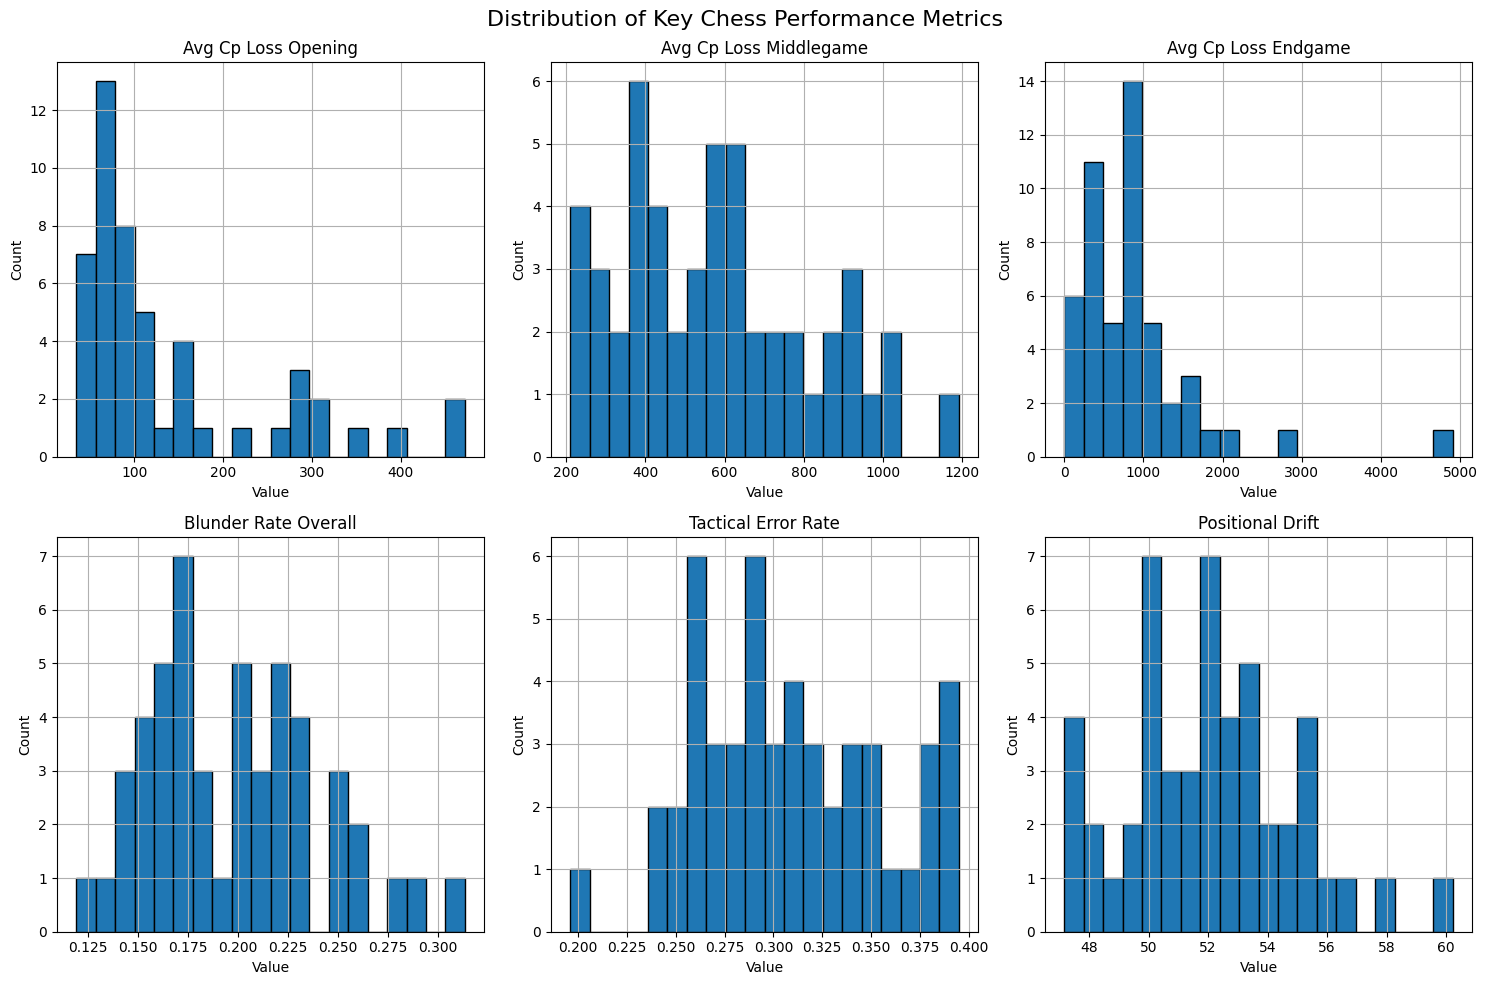


✓ Feature distributions saved to feature_distributions.png


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to DataFrame for easy analysis
df_features = pd.DataFrame(all_features)

print("Feature Statistics:")
print(df_features.describe())

# Visualize key features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Key Chess Performance Metrics', fontsize=16)

features_to_plot = [
    'avg_cp_loss_opening',
    'avg_cp_loss_middlegame',
    'avg_cp_loss_endgame',
    'blunder_rate_overall',
    'tactical_error_rate',
    'positional_drift'
]

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx // 3, idx % 3]
    df_features[feature].hist(bins=20, ax=ax, edgecolor='black')
    ax.set_title(feature.replace('_', ' ').title())
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature distributions saved to feature_distributions.png")

## Step 7: Train the Machine Learning Model
Now we train 6 separate classifiers (one for each category)

**Categories:**
1. Opening
2. Middlegame
3. Endgame
4. Tactical
5. Positional
6. Time Management

**Time:** 2-5 minutes

In [14]:
# Replace your existing training code with:
from ml_trainer_improved import ImprovedChessPlayerClassifier
import pickle

# Load your features
with open("training_features.pkl", "rb") as f:
    all_features = pickle.load(f)

# Train with adaptive thresholds
classifier = ImprovedChessPlayerClassifier(
    model_type='xgboost',
    strong_percentile=0.25,  # Adjust these as needed
    weak_percentile=0.75
)

features_df, labels_dict = classifier.prepare_training_data(all_features)
classifier.train(features_df, labels_dict)
classifier.save_models('models_adaptive')


Calculating adaptive thresholds based on data distribution...
Using percentiles - Strong: <25%, Weak: >75%
--------------------------------------------------------------------------------

OPENING:
  avg_cp_loss_opening:
    Strong: < 63.635
    Average: 63.635 - 161.343
    Weak: > 161.343
    (Mean: 139.296, Median: 81.995)
  blunder_rate_opening:
    Strong: < 0.063
    Average: 0.063 - 0.129
    Weak: > 0.129
    (Mean: 0.103, Median: 0.090)

MIDDLEGAME:
  avg_cp_loss_middlegame:
    Strong: < 387.967
    Average: 387.967 - 741.407
    Weak: > 741.407
    (Mean: 580.613, Median: 572.169)
  blunder_rate_middlegame:
    Strong: < 0.226
    Average: 0.226 - 0.286
    Weak: > 0.286
    (Mean: 0.263, Median: 0.255)

ENDGAME:
  avg_cp_loss_endgame:
    Strong: < 435.587
    Average: 435.587 - 1007.687
    Weak: > 1007.687
    (Mean: 886.520, Median: 764.040)
  blunder_rate_endgame:
    Strong: < 0.150
    Average: 0.150 - 0.267
    Weak: > 0.267
    (Mean: 0.211, Median: 0.194)

TACTICA

## Step 8: Evaluate Model Performance
Let's see how well our model performs

In [15]:
# Test prediction on a sample
test_features = all_features[0]
predictions = classifier.predict(test_features)

print("Example Prediction:")
print("=" * 50)
for category, pred in predictions.items():
    print(f"{category.upper()}:")
    print(f"  Classification: {pred['classification']}")
    print(f"  Confidence: {pred['confidence']:.2%}")
    print()

# Get strengths and weaknesses
sw = classifier.get_strengths_and_weaknesses(predictions)
print("Strengths:", sw['strengths'])
print("Weaknesses:", sw['weaknesses'])

Example Prediction:
OPENING:
  Classification: weak
  Confidence: 98.32%

MIDDLEGAME:
  Classification: weak
  Confidence: 98.74%

ENDGAME:
  Classification: average
  Confidence: 86.84%

TACTICAL:
  Classification: weak
  Confidence: 97.88%

POSITIONAL:
  Classification: strong
  Confidence: 98.88%

TIME_MANAGEMENT:
  Classification: average
  Confidence: 86.19%

Strengths: ['positional']
Weaknesses: ['opening', 'middlegame', 'tactical']


## Step 9: Save Models to Google Drive
This saves all trained models so you can use them later without retraining

In [17]:
# Create models directory
model_save_dir = os.path.join(project_dir, 'trained_models')
os.makedirs(model_save_dir, exist_ok=True)

# Save models
classifier.save_models(model_save_dir)

print(f"✓ Models saved to: {model_save_dir}")
print("\nSaved files:")
for file in os.listdir(model_save_dir):
    print(f"  - {file}")

print("\n" + "="*60)
print("SUCCESS! Your model is trained and saved.")
print("="*60)
print("\nNext steps:")
print("1. Download the 'trained_models' folder from Google Drive")
print("2. Place it in your FastAPI server directory")
print("3. Deploy the API server (instructions in deployment guide)")
print("4. Connect your Spring Boot backend to the API")


Models saved to /content/drive/MyDrive/chess_ai_project/trained_models
✓ Models saved to: /content/drive/MyDrive/chess_ai_project/trained_models

Saved files:
  - opening_model.pkl
  - middlegame_model.pkl
  - endgame_model.pkl
  - tactical_model.pkl
  - positional_model.pkl
  - time_management_model.pkl
  - opening_scaler.pkl
  - middlegame_scaler.pkl
  - endgame_scaler.pkl
  - tactical_scaler.pkl
  - positional_scaler.pkl
  - time_management_scaler.pkl
  - metadata.json

SUCCESS! Your model is trained and saved.

Next steps:
1. Download the 'trained_models' folder from Google Drive
2. Place it in your FastAPI server directory
3. Deploy the API server (instructions in deployment guide)
4. Connect your Spring Boot backend to the API


## Step 10: Test the Complete Pipeline
Let's test the entire flow with a new set of games

In [18]:
# Simulate receiving games from your Spring Boot backend
test_pgns = all_pgns[:10]  # Take 10 games

print("Testing complete analysis pipeline...\n")

# Step 1: Analyze with Stockfish
with ChessAnalyzer(stockfish_path='/usr/games/stockfish') as analyzer:
    test_analyses = analyzer.analyze_multiple_games(test_pgns, "TestPlayer")

print(f"✓ Analyzed {len(test_analyses)} games")

# Step 2: Extract features
test_features = extract_features(test_analyses)
print(f"✓ Extracted {len(test_features)} features")

# Step 3: Predict
test_predictions = classifier.predict(test_features)
print("✓ Generated predictions\n")

# Display results
print("ANALYSIS RESULTS")
print("=" * 60)
for category, pred in test_predictions.items():
    emoji = "💪" if pred['classification'] == 'strong' else "⚠️" if pred['classification'] == 'weak' else "➖"
    print(f"{emoji} {category.upper()}: {pred['classification']} ({pred['confidence']:.1%} confidence)")

print("\n" + "=" * 60)
sw = classifier.get_strengths_and_weaknesses(test_predictions)
print("\n🎯 STRENGTHS:", ', '.join(sw['strengths']) if sw['strengths'] else 'None identified')
print("⚠️ WEAKNESSES:", ', '.join(sw['weaknesses']) if sw['weaknesses'] else 'None identified')

Testing complete analysis pipeline...

✓ Analyzed 10 games
✓ Extracted 18 features
✓ Generated predictions

ANALYSIS RESULTS
⚠️ OPENING: weak (98.6% confidence)
⚠️ MIDDLEGAME: weak (98.3% confidence)
➖ ENDGAME: average (73.6% confidence)
⚠️ TACTICAL: weak (98.4% confidence)
⚠️ POSITIONAL: weak (98.1% confidence)
➖ TIME_MANAGEMENT: average (79.9% confidence)


🎯 STRENGTHS: None identified
⚠️ WEAKNESSES: opening, middlegame, tactical, positional


## Bonus: Create Model Performance Report

In [ ]:
# Generate and save a comprehensive report
report = f"""
CHESS AI MODEL TRAINING REPORT
{'='*70}

Training Date: {pd.Timestamp.now()}
Model Type: XGBoost Multi-Label Classifier

DATASET:
- Total Players: {len(all_features)}
- Games per Player: ~{games_per_player}
- Total Games Analyzed: {len(all_pgns)}

FEATURES EXTRACTED: {len(features_df.columns)}
{', '.join(features_df.columns.tolist())}

CLASSIFICATION CATEGORIES:
1. Opening (Strong/Average/Weak)
2. Middlegame (Strong/Average/Weak)
3. Endgame (Strong/Average/Weak)
4. Tactical (Strong/Average/Weak)
5. Positional (Strong/Average/Weak)
6. Time Management (Strong/Average/Weak)

MODEL FILES SAVED:
{model_save_dir}

{'='*70}
STATUS: ✓ TRAINING COMPLETE
{'='*70}
"""

print(report)

# Save report
with open(os.path.join(model_save_dir, 'training_report.txt'), 'w') as f:
    f.write(report)

print("\n✓ Report saved to trained_models/training_report.txt")

## 🎉 TRAINING COMPLETE!

### What You've Accomplished:
1. ✓ Downloaded chess games from Lichess
2. ✓ Analyzed games with Stockfish engine
3. ✓ Extracted 18+ performance features
4. ✓ Trained 6 ML classifiers (one per category)
5. ✓ Saved models to Google Drive
6. ✓ Tested the complete pipeline

### Next Steps:
1. Download the `trained_models` folder from your Google Drive
2. Follow the deployment guide to set up your FastAPI server
3. Integrate with your Spring Boot backend
4. Display results in your React frontend

### Need Help?
- Re-training: Re-run this notebook with new data
- Adjusting thresholds: Edit `ml_trainer.py` `_determine_labels()` method
- Adding features: Modify `chess_analyzer.py` `extract_features()` function

**Good luck with your chess AI project! 🎮♟️**